In [1]:
#Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import syft as sy
import sys
import pdb 
import math
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import torchvision.models as models
from random import shuffle
from torch.utils.data import SubsetRandomSampler
import torchvision.models as models
import datetime
from torch.utils.tensorboard import SummaryWriter

W1104 17:00:34.018567 49616 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted/operations/secure_random/secure_random_module_tf_1.15.0-rc3.so'
W1104 17:00:34.049553 49616 module_wrapper.py:139] From c:\users\florian\appdata\local\programs\python\python37\lib\site-packages\tf_encrypted-0.5.9-py3.7.egg\tf_encrypted\session.py:24: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [2]:
torch.set_default_tensor_type(torch.cuda.FloatTensor)
use_cuda = True
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 10
np.random.seed(1)

# Creating workers

In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker
chalie = sy.VirtualWorker(hook, id="chalie")  # <-- NEW: define remote worker
dave = sy.VirtualWorker(hook, id="dave")  # <-- NEW: define remote worker
#evelyn = sy.VirtualWorker(hook, id="evelyn")  # <-- NEW: define remote worker
#frank = sy.VirtualWorker(hook, id="frank")  # <-- NEW: define remote worker
#gustav = sy.VirtualWorker(hook, id="gustav")  # <-- NEW: define remote worker
#helmut = sy.VirtualWorker(hook, id="helmut")  # <-- NEW: define remote worker
#isabella = sy.VirtualWorker(hook, id="isabella")  # <-- NEW: define remote worker


fraudulin = sy.VirtualWorker(hook, id="fraudulin")
#fraudrich = sy.VirtualWorker(hook, id="fraudrich") 


compute_nodes = [alice, bob, chalie, dave]
frauds = [fraudulin]

# Helper function for dataset loader generation

In [4]:
def generateLoadersPerClass(dataset):
    #loaders per class
    loaders_per_class = []
    for class_name in dataset.classes:
        # get the indices in the dataset that are relative to that class
        idx = [
            pos for pos, item in enumerate(dataset.samples)
            if item[1] == dataset.class_to_idx[class_name]]
        # construct the corresponding dataloader thanks to a SubsetRandomSampler
        loaders_per_class += [torch.utils.data.DataLoader(
            dataset, 
            batch_size=batch_size,
            sampler=SubsetRandomSampler(idx),
            **kwargs)]
    return loaders_per_class

# Loading training & test datasets

In [5]:
data_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.3,saturation=0.3,contrast=0.3),
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign data
yalefaces = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original',
                             transform=data_transform)
original_loaders = generateLoadersPerClass(yalefaces)

#reloading data for deterministic testing
test_transform = transforms.Compose([
        transforms.ToTensor(),                     
        transforms.Normalize(                     
            mean=[0.485, 0.456, 0.406],               
            std=[0.229, 0.224, 0.225]                  
        )])

#benign test data
testdata = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\original_test',
                             transform=test_transform)
test_loader = torch.utils.data.DataLoader(testdata, batch_size=batch_size, **kwargs)

# Load backdoor dataset

In [6]:
backdoored = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses',
                             transform=data_transform)
#malicious data
backdoored.samples = [(d, 0) for d, s in backdoored.samples] #set each image of backdoors to 001
backdoored_loaders = generateLoadersPerClass(backdoored)


#malicious test data
backdoored_test = datasets.ImageFolder(root = 
                             'C:\\Users\Florian\\Desktop\\Datensätze_ready\\yale\\backdoors_glasses_test',
                             transform=test_transform)
#set each image of backdoors to 001
backdoored_test.samples = [(d, 0) for d, s in backdoored_test.samples]
dataset_loader_backdoored_test = torch.utils.data.DataLoader(backdoored_test, batch_size=batch_size, **kwargs)

# Visualize some training data

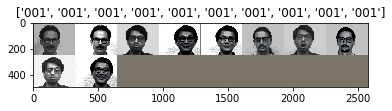

In [7]:
#Let’s visualize a few training images so as to understand the data augmentations.

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = yalefaces.classes
# Get a batch of training data
inputs, classes = next(iter(backdoored_loaders[0]))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

# Neural Network Structure

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes=len(class_names)):
        super(Net, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(-1, 256 * 6 * 6)
        x = self.classifier(x)
        return x

# Send dataset to clients

In [9]:
train_distributed_dataset = []
train_distributed_dataset_backdoor = []

#EACH CLIENT KNOWS EACH CLASS
#normal clients
for loader in original_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                target_append = target.send(compute_nodes[batch_idx % len(compute_nodes)], inplace = True)
                train_distributed_dataset.append((data_append, target_append))

#backdoored clients
for loader in backdoored_loaders:
    for batch_idx, (data,target) in enumerate(loader):
                data_append = data.send(frauds[batch_idx % len(frauds)], inplace = True)
                target_append = target.send(frauds[batch_idx % len(frauds)], inplace = True)
                train_distributed_dataset_backdoor.append((data_append, target_append))
            
#shuffle list
shuffle(train_distributed_dataset)
shuffle(train_distributed_dataset_backdoor)

#train_distributed_dataset[0]

# Training Function

In [10]:
def train(epoch, normal_or_backdoored_dataset):
    model.train()
    totalloss = 0
    number_iterations = 0
    
    for batch_idx, (data,target) in enumerate(normal_or_backdoored_dataset):   
        number_iterations +=1
        model.send(data.location) # 0) send the model to the right location
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # 1) erase previous gradients (if they exist)
        output = model(data)  # 2) make a prediction
        loss = F.cross_entropy(output, target) # 3) calculate how much we missed
        loss.backward() # 4) figure out which weights caused us to miss
        optimizer.step() # 5) change those weights
        model.get() # 6) get model (with gradients)
            
        #if batch_idx % 300 == 0:
        loss = loss.get() # <-- NEW: get the loss back
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * batch_size, len(normal_or_backdoored_dataset) * batch_size,
                100. * batch_idx / len(normal_or_backdoored_dataset), loss.item()))
        totalloss += loss
    print('Average training loss: {}'.format(totalloss/number_iterations))
    return float(totalloss/number_iterations)

# Test Function

In [11]:
def test(model, device, test_loader, length_of_dataset):
    model.eval()
    test_loss = 0
    correct = 0    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= length_of_dataset

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, length_of_dataset,
        100. * correct / length_of_dataset))
    
    #confusion matrix
    nb_classes = len(class_names)
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1)) #per class accuracy
         
    return test_loss, str((100. * correct / length_of_dataset))

# Run everyting

In [12]:
#helper function for learning rate
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [13]:
model = Net().to(device)

# stopped at:
#model.load_state_dict(torch.load("exp_faces_20191104-104602_epoch_80.pt"))
optimizer = optim.SGD(model.parameters(), lr=0.01)

#Write to file:
dateString = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

f= open(("exp_faces_"+dateString+".txt"),"w+")

#EXP-setup
csv_header = "#merge strategy: " + "sequential" + "\n"
csv_header += "#number of distributed sources: " + str(len(compute_nodes) + len(frauds)) + "\n"
csv_header += "#batch size: " + str(batch_size) + "\n"
csv_header += "#distribution of data: " + "equally distributed subset" + "\n"
csv_header += "#percentage of backdoored nodes: " + str(len(frauds)/(len(compute_nodes) + len(frauds))) + "\n"
csv_header += "#percentage of poisoned data in backdoored nodes: " + str(100) + "\n"
csv_header += "#way backdoor looks like: " + "tattoo" + "\n"
csv_header += "#order of time: " + "backdoors first" + "\n"
csv_header += "#attack model: " + "basic" + "\n"
csv_header += "#starttime: " + datetime.datetime.now().strftime("%H%M%S") + "\n"
csv_header += "training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp" + "\n"
print(csv_header)
f.write(csv_header)
f.close()


#RUN training
for epoch in range(1, 201):
    csv_normal = "normal;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    csv_backdoor = "backdoor;" + str(epoch) + ";" + str(get_lr(optimizer)) + ";"
    
    #train backdoor
    avg_training_backdoor_loss = train(epoch, train_distributed_dataset_backdoor)
    csv_backdoor += str(avg_training_backdoor_loss) + ";"
    timestamp_backdoor = datetime.datetime.now().strftime("%H%M%S")
    
    #train normal
    avg_training_loss = train(epoch, train_distributed_dataset)
    csv_normal += str(avg_training_loss) + ";"
    timestamp_normal = datetime.datetime.now().strftime("%H%M%S")

    #save after each 25 iterations
    if epoch % 25 == 0:
        torch.save(model.state_dict(), ("exp_faces_"+dateString +"_epoch_" + str(epoch) + ".pt"))
        
    #test backdoor
    test_loss, acc = test(model, device, dataset_loader_backdoored_test, len(backdoored_test))
    csv_backdoor += str(test_loss) + ";" + acc + ";"
    
    #test normal
    test_loss, acc = test(model, device, test_loader, len(testdata))
    csv_normal += str(test_loss) + ";" + acc + ";"

    #scheduler.step(test_loss)
    
    #timestamp
    csv_normal += timestamp_normal + "\n"
    csv_backdoor += timestamp_backdoor + "\n"
    
    #Write to file
    f= open(("exp_faces_"+dateString+".txt"),"a+")
    f.write(csv_backdoor)
    f.write(csv_normal)
    f.close()

    



#merge strategy: sequential
#number of distributed sources: 5
#batch size: 10
#distribution of data: equally distributed subset
#percentage of backdoored nodes: 0.2
#percentage of poisoned data in backdoored nodes: 100
#way backdoor looks like: tattoo
#order of time: backdoors first
#attack model: basic
#starttime: 170136
training_type;epoch_number;learn_rate;avg_training_loss;avg_test_loss;test_accuracy;timestamp

Train Epoch: 1 [0/30 (0%)]	Loss: 2.567491
Train Epoch: 1 [10/30 (33%)]	Loss: 2.549992
Train Epoch: 1 [20/30 (67%)]	Loss: 2.533180
Average training loss: 2.5502212047576904
Train Epoch: 1 [0/130 (0%)]	Loss: 2.580931
Train Epoch: 1 [10/130 (8%)]	Loss: 2.553820
Train Epoch: 1 [20/130 (15%)]	Loss: 2.580669
Train Epoch: 1 [30/130 (23%)]	Loss: 2.565091
Train Epoch: 1 [40/130 (31%)]	Loss: 2.564894
Train Epoch: 1 [50/130 (38%)]	Loss: 2.578230
Train Epoch: 1 [60/130 (46%)]	Loss: 2.587029
Train Epoch: 1 [70/130 (54%)]	Loss: 2.528516
Train Epoch: 1 [80/130 (62%)]	Loss: 2.595907
Train E

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 4 [0/30 (0%)]	Loss: 2.416225
Train Epoch: 4 [10/30 (33%)]	Loss: 2.391293
Train Epoch: 4 [20/30 (67%)]	Loss: 2.376336
Average training loss: 2.394617795944214
Train Epoch: 4 [0/130 (0%)]	Loss: 2.592873
Train Epoch: 4 [10/130 (8%)]	Loss: 2.571568
Train Epoch: 4 [20/130 (15%)]	Loss: 2.595730
Train Epoch: 4 [30/130 (23%)]	Loss: 2.584518
Train Epoch: 4 [40/130 (31%)]	Loss: 2.581396
Train Epoch: 4 [50/130 (38%)]	Loss: 2.589686
Train Epoch: 4 [60/130 (46%)]	Loss: 2.605819
Train Epoch: 4 [70/130 (54%)]	Loss: 2.375271
Train Epoch: 4 [80/130 (62%)]	Loss: 2.612715
Train Epoch: 4 [90/130 (69%)]	Loss: 2.598890
Train Epoch: 4 [100/130 (77%)]	Loss: 2.605679
Train Epoch: 4 [110/130 (85%)]	Loss: 2.592350
Train Epoch: 4 [120/130 (92%)]	Loss: 2.600312
Average training loss: 2.577446937561035

Test set: Average loss: 2.3607, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0.,

Train Epoch: 7 [20/30 (67%)]	Loss: 2.070439
Average training loss: 2.1400606632232666
Train Epoch: 7 [0/130 (0%)]	Loss: 2.646227
Train Epoch: 7 [10/130 (8%)]	Loss: 2.640352
Train Epoch: 7 [20/130 (15%)]	Loss: 2.644509
Train Epoch: 7 [30/130 (23%)]	Loss: 2.629909
Train Epoch: 7 [40/130 (31%)]	Loss: 2.640249
Train Epoch: 7 [50/130 (38%)]	Loss: 2.637941
Train Epoch: 7 [60/130 (46%)]	Loss: 2.648108
Train Epoch: 7 [70/130 (54%)]	Loss: 2.131473
Train Epoch: 7 [80/130 (62%)]	Loss: 2.674791
Train Epoch: 7 [90/130 (69%)]	Loss: 2.655506
Train Epoch: 7 [100/130 (77%)]	Loss: 2.649081
Train Epoch: 7 [110/130 (85%)]	Loss: 2.659950
Train Epoch: 7 [120/130 (92%)]	Loss: 2.653672
Average training loss: 2.608597755432129

Test set: Average loss: 2.1318, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Train Epoch: 10 [30/130 (23%)]	Loss: 2.685860
Train Epoch: 10 [40/130 (31%)]	Loss: 2.694493
Train Epoch: 10 [50/130 (38%)]	Loss: 2.682193
Train Epoch: 10 [60/130 (46%)]	Loss: 2.702421
Train Epoch: 10 [70/130 (54%)]	Loss: 1.983889
Train Epoch: 10 [80/130 (62%)]	Loss: 2.730170
Train Epoch: 10 [90/130 (69%)]	Loss: 2.720840
Train Epoch: 10 [100/130 (77%)]	Loss: 2.697474
Train Epoch: 10 [110/130 (85%)]	Loss: 2.702890
Train Epoch: 10 [120/130 (92%)]	Loss: 2.696216
Average training loss: 2.6390767097473145

Test set: Average loss: 2.0490, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      

Train Epoch: 13 [60/130 (46%)]	Loss: 2.732464
Train Epoch: 13 [70/130 (54%)]	Loss: 1.897869
Train Epoch: 13 [80/130 (62%)]	Loss: 2.742343
Train Epoch: 13 [90/130 (69%)]	Loss: 2.738867
Train Epoch: 13 [100/130 (77%)]	Loss: 2.729156
Train Epoch: 13 [110/130 (85%)]	Loss: 2.726389
Train Epoch: 13 [120/130 (92%)]	Loss: 2.718384
Average training loss: 2.6341564655303955

Test set: Average loss: 1.9910, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0.,

Train Epoch: 16 [90/130 (69%)]	Loss: 2.752990
Train Epoch: 16 [100/130 (77%)]	Loss: 2.749243
Train Epoch: 16 [110/130 (85%)]	Loss: 2.744847
Train Epoch: 16 [120/130 (92%)]	Loss: 2.739670
Average training loss: 2.632781505584717

Test set: Average loss: 1.9525, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.

Train Epoch: 19 [120/130 (92%)]	Loss: 2.752647
Average training loss: 2.6295671463012695

Test set: Average loss: 1.9041, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, na

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5878, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 26 [0/30 (0%)]	Loss: 1.804898
Train Epoch: 26 [10/30 (33%)]	Loss: 1.714796
Train Epoch: 26 [20/30 (67%)]	Loss: 1.65448

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 29 [0/30 (0%)]	Loss: 1.777015
Train Epoch: 29 [10/30 (33%)]	Loss: 1.679788
Train Epoch: 29 [20/30 (67%)]	Loss: 1.630444
Average training loss: 1.695749044418335
Train Epoch: 29 [0/130 (0%)]	Loss: 2.672763
Train Epoch: 29 [10/130 (8%)]	Loss: 2.659017
Train Epoch: 29 [20/130 (15%)]	Loss: 2.587708
Train Epoch: 29 [30/130 (23%)]	Loss: 2.688800
Train Epoch: 29 [40/130 (31%)]	Loss: 2.673844
Train Epoch: 29 [50/130 (38%)]	Loss: 2.670708
Train Epoch: 29 [60/130 (46%)]	Loss: 2.746325
Train Epoch: 29 [70/130 (54%)]	Loss: 1.687773
Train Epoch: 29 [80/130 (62%)]	Loss: 2.714543
Train Epoch: 29 [90/130 (69%)]	Loss: 2.779280
Train Epoch: 29 [100/130 (77%)]	Loss: 2.774704
Train Epoch: 29 [110/130 (85%)]	Loss: 2.778089
Train Epoch: 29 [120/130 (92%)]	Loss: 2.779205
Average training loss: 2.6317505836486816

Test set: Average loss: 1.7821, Accuracy: 9/9 (100%)

tensor(

Train Epoch: 32 [10/30 (33%)]	Loss: 1.654566
Train Epoch: 32 [20/30 (67%)]	Loss: 1.605385
Average training loss: 1.6689571142196655
Train Epoch: 32 [0/130 (0%)]	Loss: 2.688300
Train Epoch: 32 [10/130 (8%)]	Loss: 2.678139
Train Epoch: 32 [20/130 (15%)]	Loss: 2.587016
Train Epoch: 32 [30/130 (23%)]	Loss: 2.696712
Train Epoch: 32 [40/130 (31%)]	Loss: 2.664857
Train Epoch: 32 [50/130 (38%)]	Loss: 2.668065
Train Epoch: 32 [60/130 (46%)]	Loss: 2.735809
Train Epoch: 32 [70/130 (54%)]	Loss: 1.653879
Train Epoch: 32 [80/130 (62%)]	Loss: 2.723317
Train Epoch: 32 [90/130 (69%)]	Loss: 2.784377
Train Epoch: 32 [100/130 (77%)]	Loss: 2.775949
Train Epoch: 32 [110/130 (85%)]	Loss: 2.794195
Train Epoch: 32 [120/130 (92%)]	Loss: 2.785984
Average training loss: 2.63358473777771

Test set: Average loss: 1.7583, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

Train Epoch: 35 [10/130 (8%)]	Loss: 2.679613
Train Epoch: 35 [20/130 (15%)]	Loss: 2.595046
Train Epoch: 35 [30/130 (23%)]	Loss: 2.700049
Train Epoch: 35 [40/130 (31%)]	Loss: 2.672371
Train Epoch: 35 [50/130 (38%)]	Loss: 2.664011
Train Epoch: 35 [60/130 (46%)]	Loss: 2.736735
Train Epoch: 35 [70/130 (54%)]	Loss: 1.613984
Train Epoch: 35 [80/130 (62%)]	Loss: 2.732892
Train Epoch: 35 [90/130 (69%)]	Loss: 2.796021
Train Epoch: 35 [100/130 (77%)]	Loss: 2.772521
Train Epoch: 35 [110/130 (85%)]	Loss: 2.801685
Train Epoch: 35 [120/130 (92%)]	Loss: 2.797407
Average training loss: 2.6356842517852783

Test set: Average loss: 1.7340, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.

Train Epoch: 38 [40/130 (31%)]	Loss: 2.665276
Train Epoch: 38 [50/130 (38%)]	Loss: 2.651375
Train Epoch: 38 [60/130 (46%)]	Loss: 2.737126
Train Epoch: 38 [70/130 (54%)]	Loss: 1.617637
Train Epoch: 38 [80/130 (62%)]	Loss: 2.727042
Train Epoch: 38 [90/130 (69%)]	Loss: 2.787083
Train Epoch: 38 [100/130 (77%)]	Loss: 2.762859
Train Epoch: 38 [110/130 (85%)]	Loss: 2.786470
Train Epoch: 38 [120/130 (92%)]	Loss: 2.806526
Average training loss: 2.6347482204437256

Test set: Average loss: 1.7133, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 41 [70/130 (54%)]	Loss: 1.574581
Train Epoch: 41 [80/130 (62%)]	Loss: 2.725199
Train Epoch: 41 [90/130 (69%)]	Loss: 2.799467
Train Epoch: 41 [100/130 (77%)]	Loss: 2.779317
Train Epoch: 41 [110/130 (85%)]	Loss: 2.794821
Train Epoch: 41 [120/130 (92%)]	Loss: 2.815696
Average training loss: 2.6335885524749756

Test set: Average loss: 1.6978, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
    

Train Epoch: 44 [100/130 (77%)]	Loss: 2.775701
Train Epoch: 44 [110/130 (85%)]	Loss: 2.795911
Train Epoch: 44 [120/130 (92%)]	Loss: 2.826230
Average training loss: 2.6308348178863525

Test set: Average loss: 1.6839, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0

Average training loss: 2.631721019744873

Test set: Average loss: 1.6799, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss:

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 2.5763, Accuracy: 1/13 (8%)

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
ten


tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 54 [0/30 (0%)]	Loss: 1.620053
Train Epoch: 54 [10/30 (33%)]	Loss: 1.512862
Train Epoch: 54 [20/30 (67%)]	Loss: 1.46427

        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Train Epoch: 57 [0/30 (0%)]	Loss: 1.615580
Train Epoch: 57 [10/30 (33%)]	Loss: 1.510497
Train Epoch: 57 [20/30 (67%)]	Loss: 1.455364
Average training loss: 1.5271471738815308
Train Epoch: 57 [0/130 (0%)]	Loss: 2.768669
Train Epoch: 57 [10/130 (8%)]	Loss: 2.738512
Train Epoch: 57 [20/130 (15%)]	Loss: 2.590574
Train Epoch: 57 [30/130 (23%)]	Loss: 2.627703
Train Epoch: 57 [40/130 (31%)]	Loss: 2.597126
Train Epoch: 57 [50/130 (38%)]	Loss: 2.519922
Train Epoch: 57 [60/130 (46%)]	Loss: 2.647036
Train Epoch: 57 [70/130 (54%)]	Loss: 1.453227
Train Epoch: 57 [80/130 (62%)]	Loss: 2.656546
Train Epoch: 57 [90/130 (69%)]	Loss: 2.821554
Train Epoch: 57 [100/130 (77%)]	Loss: 2.702266
Train Epoch: 57 [110/130 (85%)]	Loss: 2.817674
Train Epoch: 57 [120/130 (92%)]	Loss: 2.925277
Average training loss: 2.605083465576172

Test set: Average loss: 1.7362, Accuracy: 9/9 (100%)

tensor(

Train Epoch: 60 [10/30 (33%)]	Loss: 1.506921
Train Epoch: 60 [20/30 (67%)]	Loss: 1.423101
Average training loss: 1.5222110748291016
Train Epoch: 60 [0/130 (0%)]	Loss: 2.777341
Train Epoch: 60 [10/130 (8%)]	Loss: 2.745706
Train Epoch: 60 [20/130 (15%)]	Loss: 2.588647
Train Epoch: 60 [30/130 (23%)]	Loss: 2.586473
Train Epoch: 60 [40/130 (31%)]	Loss: 2.570118
Train Epoch: 60 [50/130 (38%)]	Loss: 2.468497
Train Epoch: 60 [60/130 (46%)]	Loss: 2.601896
Train Epoch: 60 [70/130 (54%)]	Loss: 1.407148
Train Epoch: 60 [80/130 (62%)]	Loss: 2.620895
Train Epoch: 60 [90/130 (69%)]	Loss: 2.825516
Train Epoch: 60 [100/130 (77%)]	Loss: 2.652569
Train Epoch: 60 [110/130 (85%)]	Loss: 2.782851
Train Epoch: 60 [120/130 (92%)]	Loss: 2.963325
Average training loss: 2.5839216709136963

Test set: Average loss: 1.7997, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

Train Epoch: 63 [10/130 (8%)]	Loss: 2.829320
Train Epoch: 63 [20/130 (15%)]	Loss: 2.601295
Train Epoch: 63 [30/130 (23%)]	Loss: 2.463417
Train Epoch: 63 [40/130 (31%)]	Loss: 2.501451
Train Epoch: 63 [50/130 (38%)]	Loss: 2.477313
Train Epoch: 63 [60/130 (46%)]	Loss: 2.506249
Train Epoch: 63 [70/130 (54%)]	Loss: 1.415488
Train Epoch: 63 [80/130 (62%)]	Loss: 2.550149
Train Epoch: 63 [90/130 (69%)]	Loss: 2.800457
Train Epoch: 63 [100/130 (77%)]	Loss: 2.420353
Train Epoch: 63 [110/130 (85%)]	Loss: 2.682929
Train Epoch: 63 [120/130 (92%)]	Loss: 2.971920
Average training loss: 2.5471763610839844

Test set: Average loss: 1.9317, Accuracy: 9/9 (100%)

tensor([[9., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0.

Train Epoch: 66 [30/130 (23%)]	Loss: 2.202288
Train Epoch: 66 [40/130 (31%)]	Loss: 2.515838
Train Epoch: 66 [50/130 (38%)]	Loss: 2.545673
Train Epoch: 66 [60/130 (46%)]	Loss: 2.460428
Train Epoch: 66 [70/130 (54%)]	Loss: 1.442385
Train Epoch: 66 [80/130 (62%)]	Loss: 2.590929
Train Epoch: 66 [90/130 (69%)]	Loss: 2.694034
Train Epoch: 66 [100/130 (77%)]	Loss: 2.314770
Train Epoch: 66 [110/130 (85%)]	Loss: 2.429365
Train Epoch: 66 [120/130 (92%)]	Loss: 2.869857
Average training loss: 2.503209352493286

Test set: Average loss: 2.0929, Accuracy: 1/9 (11%)

tensor([[1., 0., 6., 0., 0., 2., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        

Train Epoch: 69 [50/130 (38%)]	Loss: 2.548722
Train Epoch: 69 [60/130 (46%)]	Loss: 2.238052
Train Epoch: 69 [70/130 (54%)]	Loss: 1.691711
Train Epoch: 69 [80/130 (62%)]	Loss: 2.543065
Train Epoch: 69 [90/130 (69%)]	Loss: 2.689186
Train Epoch: 69 [100/130 (77%)]	Loss: 2.389940
Train Epoch: 69 [110/130 (85%)]	Loss: 2.324278
Train Epoch: 69 [120/130 (92%)]	Loss: 2.460198
Average training loss: 2.4425160884857178

Test set: Average loss: 2.0694, Accuracy: 0/9 (0%)

tensor([[0., 0., 6., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0

Train Epoch: 72 [70/130 (54%)]	Loss: 2.211839
Train Epoch: 72 [80/130 (62%)]	Loss: 2.467273
Train Epoch: 72 [90/130 (69%)]	Loss: 2.609655
Train Epoch: 72 [100/130 (77%)]	Loss: 2.315120
Train Epoch: 72 [110/130 (85%)]	Loss: 2.373766
Train Epoch: 72 [120/130 (92%)]	Loss: 2.354789
Average training loss: 2.37593412399292

Test set: Average loss: 1.9418, Accuracy: 3/9 (33%)

tensor([[3., 0., 3., 0., 0., 2., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       

Train Epoch: 75 [90/130 (69%)]	Loss: 2.513493
Train Epoch: 75 [100/130 (77%)]	Loss: 2.282885
Train Epoch: 75 [110/130 (85%)]	Loss: 2.009435
Train Epoch: 75 [120/130 (92%)]	Loss: 2.040320
Average training loss: 2.1833248138427734

Test set: Average loss: 2.9529, Accuracy: 0/9 (0%)

tensor([[0., 0., 5., 0., 0., 1., 0., 0., 0., 0., 2., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.,

Train Epoch: 78 [120/130 (92%)]	Loss: 1.803940
Average training loss: 2.1042063236236572

Test set: Average loss: 3.1636, Accuracy: 0/9 (0%)

tensor([[0., 1., 4., 0., 0., 0., 0., 0., 0., 0., 3., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., nan, nan, nan, nan, nan, nan, nan, nan,

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

Test set: Average loss: 1.9804, Accuracy: 2/13 (15%)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
te

           nan,    nan,    nan,    nan])

Test set: Average loss: 2.0019, Accuracy: 2/13 (15%)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
Train Epoch: 85 [0/30 (0%)]	Loss: 2.

        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])
Train Epoch: 88 [0/30 (0%)]	Loss: 2.054473
Train Epoch: 88 [10/30 (33%)]	Loss: 1.005684
Train Epoch: 88 [20/30 (67%)]	Loss: 0.437188
Average training loss: 1.1657819747924805
Train Epoch: 88 [0/130 (0%)]	Loss: 2.176011
Train Epoch: 88 [10/130 (8%)]	Loss: 0.936481
Train Epoch: 88 [20/130 (15%)]	Loss: 1.662534
Train Epoch: 88 [30/130 (23%)]	Loss: 1.167177
Train Epoch: 88 [40/130 (31%)]	Loss: 1.737930
Train Epoch: 88 [50/130 (38%)]	Loss: 2.506269
Train Epoch: 88 [60/130 (46%)]	Loss: 1.493304
Train Epoch: 88 [70/130 (54%)]	Loss: 1.445696
Train Epoch: 88 [80/130 (62%)]	Loss: 1.321982
Train Epoch: 88 [90/130 (69%)]	Loss: 1.733427
Train Epoch: 88 [100/130 (77%)]	Loss: 1.417723
Train Epoch: 88 [110/130 (85%)]	Loss: 0.842347
Train Epoch: 88 [120/130 (92%)]	Loss: 1.775661
Average training loss: 1.5551187992095947

Test set: Average loss: 4.9641, Accuracy: 1/9 (11%)

tensor(

tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
Train Epoch: 91 [0/30 (0%)]	Loss: 1.428521
Train Epoch: 91 [10/30 (33%)]	Loss: 0.357856
Train Epoch: 91 [20/30 (67%)]	Loss: 0.132434
Average training loss: 0.6396036148071289
Train Epoch: 91 [0/130 (0%)]	Loss: 2.224437
Train Epoch: 91 [10/130 (8%)]	Loss: 1.222647
Train Epoch: 91 [20/130 (15%)]	Loss: 2.816072
Train Epoch: 91 [30/130 (23%)]	Loss: 1.030673
Train Epoch: 91 [40/130 (31%)]	Loss: 0.949923
Train Epoch: 91 [50/130 (38%)]	Loss: 2.202833
Train Epoch: 91 [60/130 (46%)]	Loss: 1.978416
Train Epoch: 91 [70/130 (54%)]	Loss: 1.532932
Train Epoch: 91 [80/130 (62%)]	Loss: 0.755627
Train Epoch: 91 [90/130 (69%)]	Loss: 1.978179
Train Epoch: 91 [100/130 (77%)]	Loss: 1.915217
Train Epoch: 91 [110/130 (85%)]	Loss: 1.275639
Train Epoch: 91 [120/130 (92%)]	Loss: 1.340929
Average training loss: 1.632578730583191

Test set: Average loss: 3.9930, Accuracy: 2/9 (22%)

tensor([[2., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 2., 0.],
        [

tensor([0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0.])
Train Epoch: 94 [0/30 (0%)]	Loss: 1.385847
Train Epoch: 94 [10/30 (33%)]	Loss: 0.573946
Train Epoch: 94 [20/30 (67%)]	Loss: 0.329163
Average training loss: 0.7629852294921875
Train Epoch: 94 [0/130 (0%)]	Loss: 1.644975
Train Epoch: 94 [10/130 (8%)]	Loss: 1.397593
Train Epoch: 94 [20/130 (15%)]	Loss: 1.618079
Train Epoch: 94 [30/130 (23%)]	Loss: 0.934123
Train Epoch: 94 [40/130 (31%)]	Loss: 2.035671
Train Epoch: 94 [50/130 (38%)]	Loss: 1.776863
Train Epoch: 94 [60/130 (46%)]	Loss: 1.212696
Train Epoch: 94 [70/130 (54%)]	Loss: 1.517738
Train Epoch: 94 [80/130 (62%)]	Loss: 0.095330
Train Epoch: 94 [90/130 (69%)]	Loss: 1.550080
Train Epoch: 94 [100/130 (77%)]	Loss: 1.487814
Train Epoch: 94 [110/130 (85%)]	Loss: 1.208493
Train Epoch: 94 [120/130 (92%)]	Loss: 1.418830
Average training loss: 1.37679123878479

Test set: Average loss: 5.3724, Accuracy: 1/9 (11%)

tensor([[1., 1., 2., 0., 0., 0., 1., 0., 0., 0., 1., 1., 2.],
        [0

tensor([0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0.])
Train Epoch: 97 [0/30 (0%)]	Loss: 2.085690
Train Epoch: 97 [10/30 (33%)]	Loss: 0.700126
Train Epoch: 97 [20/30 (67%)]	Loss: 0.249448
Average training loss: 1.0117547512054443
Train Epoch: 97 [0/130 (0%)]	Loss: 3.024987
Train Epoch: 97 [10/130 (8%)]	Loss: 0.870771
Train Epoch: 97 [20/130 (15%)]	Loss: 1.973428
Train Epoch: 97 [30/130 (23%)]	Loss: 0.703752
Train Epoch: 97 [40/130 (31%)]	Loss: 1.009345
Train Epoch: 97 [50/130 (38%)]	Loss: 1.095483
Train Epoch: 97 [60/130 (46%)]	Loss: 1.507241
Train Epoch: 97 [70/130 (54%)]	Loss: 0.546965
Train Epoch: 97 [80/130 (62%)]	Loss: 1.377116
Train Epoch: 97 [90/130 (69%)]	Loss: 1.143923
Train Epoch: 97 [100/130 (77%)]	Loss: 1.268046
Train Epoch: 97 [110/130 (85%)]	Loss: 1.223118
Train Epoch: 97 [120/130 (92%)]	Loss: 1.088005
Average training loss: 1.294783115386963

Test set: Average loss: 4.8650, Accuracy: 2/9 (22%)

tensor([[2., 0., 3., 0., 0., 1., 0., 0., 0., 0., 3., 0., 0.],
        [

tensor([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.])
Train Epoch: 100 [0/30 (0%)]	Loss: 2.525931
Train Epoch: 100 [10/30 (33%)]	Loss: 0.151098
Train Epoch: 100 [20/30 (67%)]	Loss: 0.075793
Average training loss: 0.9176074862480164
Train Epoch: 100 [0/130 (0%)]	Loss: 1.425782
Train Epoch: 100 [10/130 (8%)]	Loss: 1.846825
Train Epoch: 100 [20/130 (15%)]	Loss: 1.123115
Train Epoch: 100 [30/130 (23%)]	Loss: 0.332543
Train Epoch: 100 [40/130 (31%)]	Loss: 2.197729
Train Epoch: 100 [50/130 (38%)]	Loss: 2.340542
Train Epoch: 100 [60/130 (46%)]	Loss: 1.348156
Train Epoch: 100 [70/130 (54%)]	Loss: 1.556400
Train Epoch: 100 [80/130 (62%)]	Loss: 0.853724
Train Epoch: 100 [90/130 (69%)]	Loss: 1.099146
Train Epoch: 100 [100/130 (77%)]	Loss: 1.406421
Train Epoch: 100 [110/130 (85%)]	Loss: 0.653725
Train Epoch: 100 [120/130 (92%)]	Loss: 0.772978
Average training loss: 1.3043912649154663

Test set: Average loss: 7.1172, Accuracy: 1/9 (11%)

tensor([[1., 1., 3., 0., 0., 0., 1., 0., 1., 0., 1., 1

tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0.])
Train Epoch: 103 [0/30 (0%)]	Loss: 1.818286
Train Epoch: 103 [10/30 (33%)]	Loss: 0.012405
Train Epoch: 103 [20/30 (67%)]	Loss: 0.023843
Average training loss: 0.618178129196167
Train Epoch: 103 [0/130 (0%)]	Loss: 2.465308
Train Epoch: 103 [10/130 (8%)]	Loss: 1.389200
Train Epoch: 103 [20/130 (15%)]	Loss: 2.011846
Train Epoch: 103 [30/130 (23%)]	Loss: 0.199730
Train Epoch: 103 [40/130 (31%)]	Loss: 1.162064
Train Epoch: 103 [50/130 (38%)]	Loss: 1.030540
Train Epoch: 103 [60/130 (46%)]	Loss: 1.062168
Train Epoch: 103 [70/130 (54%)]	Loss: 0.588091
Train Epoch: 103 [80/130 (62%)]	Loss: 0.179615
Train Epoch: 103 [90/130 (69%)]	Loss: 0.880093
Train Epoch: 103 [100/130 (77%)]	Loss: 1.625033
Train Epoch: 103 [110/130 (85%)]	Loss: 0.590429
Train Epoch: 103 [120/130 (92%)]	Loss: 0.495480
Average training loss: 1.052276849746704

Test set: Average loss: 8.0621, Accuracy: 0/9 (0%)

tensor([[0., 1., 2., 0., 0., 1., 1., 0., 1., 0., 1., 1., 

Train Epoch: 106 [10/30 (33%)]	Loss: 0.181634
Train Epoch: 106 [20/30 (67%)]	Loss: 0.119178
Average training loss: 0.8438073992729187
Train Epoch: 106 [0/130 (0%)]	Loss: 0.534325
Train Epoch: 106 [10/130 (8%)]	Loss: 0.311907
Train Epoch: 106 [20/130 (15%)]	Loss: 1.599855
Train Epoch: 106 [30/130 (23%)]	Loss: 0.532333
Train Epoch: 106 [40/130 (31%)]	Loss: 0.541434
Train Epoch: 106 [50/130 (38%)]	Loss: 1.609279
Train Epoch: 106 [60/130 (46%)]	Loss: 0.654799
Train Epoch: 106 [70/130 (54%)]	Loss: 0.253168
Train Epoch: 106 [80/130 (62%)]	Loss: 0.007885
Train Epoch: 106 [90/130 (69%)]	Loss: 0.095610
Train Epoch: 106 [100/130 (77%)]	Loss: 1.098861
Train Epoch: 106 [110/130 (85%)]	Loss: 0.594460
Train Epoch: 106 [120/130 (92%)]	Loss: 0.207972
Average training loss: 0.6186068058013916

Test set: Average loss: 9.9107, Accuracy: 2/9 (22%)

tensor([[2., 1., 2., 0., 0., 0., 0., 1., 0., 0., 1., 2., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.

Train Epoch: 109 [10/30 (33%)]	Loss: 0.101605
Train Epoch: 109 [20/30 (67%)]	Loss: 0.163732
Average training loss: 0.7286192178726196
Train Epoch: 109 [0/130 (0%)]	Loss: 0.259436
Train Epoch: 109 [10/130 (8%)]	Loss: 0.348421
Train Epoch: 109 [20/130 (15%)]	Loss: 1.643717
Train Epoch: 109 [30/130 (23%)]	Loss: 0.455445
Train Epoch: 109 [40/130 (31%)]	Loss: 0.542868
Train Epoch: 109 [50/130 (38%)]	Loss: 0.674788
Train Epoch: 109 [60/130 (46%)]	Loss: 0.629014
Train Epoch: 109 [70/130 (54%)]	Loss: 0.505445
Train Epoch: 109 [80/130 (62%)]	Loss: 0.047532
Train Epoch: 109 [90/130 (69%)]	Loss: 0.655215
Train Epoch: 109 [100/130 (77%)]	Loss: 0.691516
Train Epoch: 109 [110/130 (85%)]	Loss: 0.051597
Train Epoch: 109 [120/130 (92%)]	Loss: 0.702102
Average training loss: 0.5543920993804932

Test set: Average loss: 10.7204, Accuracy: 0/9 (0%)

tensor([[0., 1., 0., 1., 0., 1., 1., 2., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0.

Train Epoch: 112 [10/30 (33%)]	Loss: 0.462861
Train Epoch: 112 [20/30 (67%)]	Loss: 0.181712
Average training loss: 0.4686824679374695
Train Epoch: 112 [0/130 (0%)]	Loss: 0.286472
Train Epoch: 112 [10/130 (8%)]	Loss: 0.817357
Train Epoch: 112 [20/130 (15%)]	Loss: 1.367350
Train Epoch: 112 [30/130 (23%)]	Loss: 0.036889
Train Epoch: 112 [40/130 (31%)]	Loss: 1.338354
Train Epoch: 112 [50/130 (38%)]	Loss: 0.805923
Train Epoch: 112 [60/130 (46%)]	Loss: 0.164141
Train Epoch: 112 [70/130 (54%)]	Loss: 0.743327
Train Epoch: 112 [80/130 (62%)]	Loss: 0.020678
Train Epoch: 112 [90/130 (69%)]	Loss: 0.181821
Train Epoch: 112 [100/130 (77%)]	Loss: 0.657846
Train Epoch: 112 [110/130 (85%)]	Loss: 0.195605
Train Epoch: 112 [120/130 (92%)]	Loss: 0.861799
Average training loss: 0.5751971006393433

Test set: Average loss: 10.6733, Accuracy: 1/9 (11%)

tensor([[1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 2.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0

Train Epoch: 115 [0/30 (0%)]	Loss: 2.513271
Train Epoch: 115 [10/30 (33%)]	Loss: 0.034621
Train Epoch: 115 [20/30 (67%)]	Loss: 0.133021
Average training loss: 0.8936375379562378
Train Epoch: 115 [0/130 (0%)]	Loss: 0.180622
Train Epoch: 115 [10/130 (8%)]	Loss: 0.230859
Train Epoch: 115 [20/130 (15%)]	Loss: 1.734421
Train Epoch: 115 [30/130 (23%)]	Loss: 0.205165
Train Epoch: 115 [40/130 (31%)]	Loss: 2.815651
Train Epoch: 115 [50/130 (38%)]	Loss: 1.845520
Train Epoch: 115 [60/130 (46%)]	Loss: 0.403303
Train Epoch: 115 [70/130 (54%)]	Loss: 0.451938
Train Epoch: 115 [80/130 (62%)]	Loss: 0.009416
Train Epoch: 115 [90/130 (69%)]	Loss: 0.090412
Train Epoch: 115 [100/130 (77%)]	Loss: 1.662294
Train Epoch: 115 [110/130 (85%)]	Loss: 0.305924
Train Epoch: 115 [120/130 (92%)]	Loss: 0.507524
Average training loss: 0.8033115863800049

Test set: Average loss: 7.6561, Accuracy: 1/9 (11%)

tensor([[1., 1., 1., 1., 0., 0., 1., 2., 0., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

tensor([0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
Train Epoch: 118 [0/30 (0%)]	Loss: 1.512598
Train Epoch: 118 [10/30 (33%)]	Loss: 0.070088
Train Epoch: 118 [20/30 (67%)]	Loss: 0.128713
Average training loss: 0.5704666376113892
Train Epoch: 118 [0/130 (0%)]	Loss: 0.264679
Train Epoch: 118 [10/130 (8%)]	Loss: 0.965342
Train Epoch: 118 [20/130 (15%)]	Loss: 1.096924
Train Epoch: 118 [30/130 (23%)]	Loss: 0.126097
Train Epoch: 118 [40/130 (31%)]	Loss: 0.368144
Train Epoch: 118 [50/130 (38%)]	Loss: 0.167298
Train Epoch: 118 [60/130 (46%)]	Loss: 0.061786
Train Epoch: 118 [70/130 (54%)]	Loss: 0.629283
Train Epoch: 118 [80/130 (62%)]	Loss: 0.070285
Train Epoch: 118 [90/130 (69%)]	Loss: 0.043209
Train Epoch: 118 [100/130 (77%)]	Loss: 1.151929
Train Epoch: 118 [110/130 (85%)]	Loss: 0.202886
Train Epoch: 118 [120/130 (92%)]	Loss: 0.776352
Average training loss: 0.4557088017463684

Test set: Average loss: 10.7663, Accuracy: 0/9 (0%)

tensor([[0., 1., 0., 1., 0., 1., 1., 2., 0., 0., 1., 1

tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 121 [0/30 (0%)]	Loss: 0.037053
Train Epoch: 121 [10/30 (33%)]	Loss: 0.419924
Train Epoch: 121 [20/30 (67%)]	Loss: 0.022085
Average training loss: 0.15968728065490723
Train Epoch: 121 [0/130 (0%)]	Loss: 0.113258
Train Epoch: 121 [10/130 (8%)]	Loss: 0.207196
Train Epoch: 121 [20/130 (15%)]	Loss: 0.016868
Train Epoch: 121 [30/130 (23%)]	Loss: 0.066710
Train Epoch: 121 [40/130 (31%)]	Loss: 0.001317
Train Epoch: 121 [50/130 (38%)]	Loss: 1.016687
Train Epoch: 121 [60/130 (46%)]	Loss: 1.143027
Train Epoch: 121 [70/130 (54%)]	Loss: 1.817870
Train Epoch: 121 [80/130 (62%)]	Loss: 0.052830
Train Epoch: 121 [90/130 (69%)]	Loss: 0.485994
Train Epoch: 121 [100/130 (77%)]	Loss: 0.880380
Train Epoch: 121 [110/130 (85%)]	Loss: 8.149473
Train Epoch: 121 [120/130 (92%)]	Loss: 1.200672
Average training loss: 1.1655601263046265

Test set: Average loss: 4.6790, Accuracy: 0/9 (0%)

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 9., 0

tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 124 [0/30 (0%)]	Loss: 2.423312
Train Epoch: 124 [10/30 (33%)]	Loss: 0.140269
Train Epoch: 124 [20/30 (67%)]	Loss: 0.219813
Average training loss: 0.9277980327606201
Train Epoch: 124 [0/130 (0%)]	Loss: 0.649939
Train Epoch: 124 [10/130 (8%)]	Loss: 0.347686
Train Epoch: 124 [20/130 (15%)]	Loss: 2.226657
Train Epoch: 124 [30/130 (23%)]	Loss: 0.167832
Train Epoch: 124 [40/130 (31%)]	Loss: 0.453596
Train Epoch: 124 [50/130 (38%)]	Loss: 0.119340
Train Epoch: 124 [60/130 (46%)]	Loss: 0.201852
Train Epoch: 124 [70/130 (54%)]	Loss: 0.024022
Train Epoch: 124 [80/130 (62%)]	Loss: 0.001210
Train Epoch: 124 [90/130 (69%)]	Loss: 0.128648
Train Epoch: 124 [100/130 (77%)]	Loss: 0.546677
Train Epoch: 124 [110/130 (85%)]	Loss: 0.090919
Train Epoch: 124 [120/130 (92%)]	Loss: 0.048591
Average training loss: 0.38515135645866394

Test set: Average loss: 4.9175, Accuracy: 3/9 (33%)

tensor([[3., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1.])
Train Epoch: 127 [0/30 (0%)]	Loss: 0.329619
Train Epoch: 127 [10/30 (33%)]	Loss: 0.193822
Train Epoch: 127 [20/30 (67%)]	Loss: 0.066328
Average training loss: 0.1965898722410202
Train Epoch: 127 [0/130 (0%)]	Loss: 0.384694
Train Epoch: 127 [10/130 (8%)]	Loss: 3.584871
Train Epoch: 127 [20/130 (15%)]	Loss: 1.011508
Train Epoch: 127 [30/130 (23%)]	Loss: 0.022361
Train Epoch: 127 [40/130 (31%)]	Loss: 0.227762
Train Epoch: 127 [50/130 (38%)]	Loss: 2.916665
Train Epoch: 127 [60/130 (46%)]	Loss: 0.974474
Train Epoch: 127 [70/130 (54%)]	Loss: 3.086999
Train Epoch: 127 [80/130 (62%)]	Loss: 1.610014
Train Epoch: 127 [90/130 (69%)]	Loss: 0.452846
Train Epoch: 127 [100/130 (77%)]	Loss: 0.423569
Train Epoch: 127 [110/130 (85%)]	Loss: 0.671471
Train Epoch: 127 [120/130 (92%)]	Loss: 0.244309
Average training loss: 1.20088791847229

Test set: Average loss: 4.2719, Accuracy: 3/9 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 130 [0/30 (0%)]	Loss: 0.168204
Train Epoch: 130 [10/30 (33%)]	Loss: 0.057838
Train Epoch: 130 [20/30 (67%)]	Loss: 0.124042
Average training loss: 0.11669467389583588
Train Epoch: 130 [0/130 (0%)]	Loss: 4.213611
Train Epoch: 130 [10/130 (8%)]	Loss: 3.871701
Train Epoch: 130 [20/130 (15%)]	Loss: 0.325419
Train Epoch: 130 [30/130 (23%)]	Loss: 0.085494
Train Epoch: 130 [40/130 (31%)]	Loss: 0.253098
Train Epoch: 130 [50/130 (38%)]	Loss: 0.986075
Train Epoch: 130 [60/130 (46%)]	Loss: 0.383348
Train Epoch: 130 [70/130 (54%)]	Loss: 0.111397
Train Epoch: 130 [80/130 (62%)]	Loss: 0.021706
Train Epoch: 130 [90/130 (69%)]	Loss: 0.125410
Train Epoch: 130 [100/130 (77%)]	Loss: 0.210462
Train Epoch: 130 [110/130 (85%)]	Loss: 0.041752
Train Epoch: 130 [120/130 (92%)]	Loss: 0.093851
Average training loss: 0.8248710036277771

Test set: Average loss: 3.8437, Accuracy: 4

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 133 [0/30 (0%)]	Loss: 0.037615
Train Epoch: 133 [10/30 (33%)]	Loss: 0.226196
Train Epoch: 133 [20/30 (67%)]	Loss: 0.002748
Average training loss: 0.0888529047369957
Train Epoch: 133 [0/130 (0%)]	Loss: 0.024200
Train Epoch: 133 [10/130 (8%)]	Loss: 0.030134
Train Epoch: 133 [20/130 (15%)]	Loss: 0.018079
Train Epoch: 133 [30/130 (23%)]	Loss: 0.006869
Train Epoch: 133 [40/130 (31%)]	Loss: 0.002348
Train Epoch: 133 [50/130 (38%)]	Loss: 0.363670
Train Epoch: 133 [60/130 (46%)]	Loss: 0.021600
Train Epoch: 133 [70/130 (54%)]	Loss: 0.029955
Train Epoch: 133 [80/130 (62%)]	Loss: 0.000010
Train Epoch: 133 [90/130 (69%)]	Loss: 0.036773
Train Epoch: 133 [100/130 (77%)]	Loss: 0.077614
Train Epoch: 133 [110/130 (85%)]	Loss: 0.015268
Train Epoch: 133 [120/130 (92%)]	Loss: 0.024210
Average training loss: 0.050056084990501404

Test set: Average loss: 6.1663, Accuracy: 

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 136 [0/30 (0%)]	Loss: 0.002198
Train Epoch: 136 [10/30 (33%)]	Loss: 0.003360
Train Epoch: 136 [20/30 (67%)]	Loss: 0.010545
Average training loss: 0.0053674220107495785
Train Epoch: 136 [0/130 (0%)]	Loss: 0.013796
Train Epoch: 136 [10/130 (8%)]	Loss: 0.003881
Train Epoch: 136 [20/130 (15%)]	Loss: 0.006484
Train Epoch: 136 [30/130 (23%)]	Loss: 0.000561
Train Epoch: 136 [40/130 (31%)]	Loss: 0.000168
Train Epoch: 136 [50/130 (38%)]	Loss: 0.003563
Train Epoch: 136 [60/130 (46%)]	Loss: 0.009431
Train Epoch: 136 [70/130 (54%)]	Loss: 0.009866
Train Epoch: 136 [80/130 (62%)]	Loss: 0.000023
Train Epoch: 136 [90/130 (69%)]	Loss: 0.003827
Train Epoch: 136 [100/130 (77%)]	Loss: 0.013605
Train Epoch: 136 [110/130 (85%)]	Loss: 0.003030
Train Epoch: 136 [120/130 (92%)]	Loss: 0.009131
Average training loss: 0.005951142869889736

Test set: Average loss: 6.2393, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 139 [0/30 (0%)]	Loss: 0.000694
Train Epoch: 139 [10/30 (33%)]	Loss: 0.000567
Train Epoch: 139 [20/30 (67%)]	Loss: 0.002727
Average training loss: 0.0013291914947330952
Train Epoch: 139 [0/130 (0%)]	Loss: 0.009602
Train Epoch: 139 [10/130 (8%)]	Loss: 0.004659
Train Epoch: 139 [20/130 (15%)]	Loss: 0.002498
Train Epoch: 139 [30/130 (23%)]	Loss: 0.000298
Train Epoch: 139 [40/130 (31%)]	Loss: 0.001336
Train Epoch: 139 [50/130 (38%)]	Loss: 0.006400
Train Epoch: 139 [60/130 (46%)]	Loss: 0.001369
Train Epoch: 139 [70/130 (54%)]	Loss: 0.045891
Train Epoch: 139 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 139 [90/130 (69%)]	Loss: 0.002552
Train Epoch: 139 [100/130 (77%)]	Loss: 0.006689
Train Epoch: 139 [110/130 (85%)]	Loss: 0.000052
Train Epoch: 139 [120/130 (92%)]	Loss: 0.009917
Average training loss: 0.007020292803645134

Test set: Average loss: 5.9778, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 142 [0/30 (0%)]	Loss: 0.000439
Train Epoch: 142 [10/30 (33%)]	Loss: 0.000144
Train Epoch: 142 [20/30 (67%)]	Loss: 0.024216
Average training loss: 0.008266529068350792
Train Epoch: 142 [0/130 (0%)]	Loss: 0.016922
Train Epoch: 142 [10/130 (8%)]	Loss: 0.002233
Train Epoch: 142 [20/130 (15%)]	Loss: 0.000462
Train Epoch: 142 [30/130 (23%)]	Loss: 0.000749
Train Epoch: 142 [40/130 (31%)]	Loss: 0.000086
Train Epoch: 142 [50/130 (38%)]	Loss: 0.003424
Train Epoch: 142 [60/130 (46%)]	Loss: 0.000558
Train Epoch: 142 [70/130 (54%)]	Loss: 0.000051
Train Epoch: 142 [80/130 (62%)]	Loss: 0.000209
Train Epoch: 142 [90/130 (69%)]	Loss: 0.001622
Train Epoch: 142 [100/130 (77%)]	Loss: 0.007756
Train Epoch: 142 [110/130 (85%)]	Loss: 0.000081
Train Epoch: 142 [120/130 (92%)]	Loss: 0.001390
Average training loss: 0.002733988454565406

Test set: Average loss: 6.2275, Accuracy

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 145 [0/30 (0%)]	Loss: 0.000887
Train Epoch: 145 [10/30 (33%)]	Loss: 0.002584
Train Epoch: 145 [20/30 (67%)]	Loss: 0.000534
Average training loss: 0.0013347864151000977
Train Epoch: 145 [0/130 (0%)]	Loss: 0.002267
Train Epoch: 145 [10/130 (8%)]	Loss: 0.005244
Train Epoch: 145 [20/130 (15%)]	Loss: 0.000603
Train Epoch: 145 [30/130 (23%)]	Loss: 0.000373
Train Epoch: 145 [40/130 (31%)]	Loss: 0.000120
Train Epoch: 145 [50/130 (38%)]	Loss: 0.001707
Train Epoch: 145 [60/130 (46%)]	Loss: 0.000563
Train Epoch: 145 [70/130 (54%)]	Loss: 0.000080
Train Epoch: 145 [80/130 (62%)]	Loss: 0.000007
Train Epoch: 145 [90/130 (69%)]	Loss: 0.000726
Train Epoch: 145 [100/130 (77%)]	Loss: 0.002165
Train Epoch: 145 [110/130 (85%)]	Loss: 0.000088
Train Epoch: 145 [120/130 (92%)]	Loss: 0.001898
Average training loss: 0.0012186054373160005

Test set: Average loss: 6.5850, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 148 [0/30 (0%)]	Loss: 0.000023
Train Epoch: 148 [10/30 (33%)]	Loss: 0.000126
Train Epoch: 148 [20/30 (67%)]	Loss: 0.007560
Average training loss: 0.0025696675293147564
Train Epoch: 148 [0/130 (0%)]	Loss: 0.001532
Train Epoch: 148 [10/130 (8%)]	Loss: 0.010636
Train Epoch: 148 [20/130 (15%)]	Loss: 0.000982
Train Epoch: 148 [30/130 (23%)]	Loss: 0.000189
Train Epoch: 148 [40/130 (31%)]	Loss: 0.000211
Train Epoch: 148 [50/130 (38%)]	Loss: 0.001096
Train Epoch: 148 [60/130 (46%)]	Loss: 0.002074
Train Epoch: 148 [70/130 (54%)]	Loss: 0.000528
Train Epoch: 148 [80/130 (62%)]	Loss: 0.000007
Train Epoch: 148 [90/130 (69%)]	Loss: 0.000325
Train Epoch: 148 [100/130 (77%)]	Loss: 0.002732
Train Epoch: 148 [110/130 (85%)]	Loss: 0.000060
Train Epoch: 148 [120/130 (92%)]	Loss: 0.000109
Average training loss: 0.0015753388870507479

Test set: Average loss: 6.8326, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 151 [0/30 (0%)]	Loss: 0.000152
Train Epoch: 151 [10/30 (33%)]	Loss: 0.002019
Train Epoch: 151 [20/30 (67%)]	Loss: 0.000198
Average training loss: 0.000789896585047245
Train Epoch: 151 [0/130 (0%)]	Loss: 0.006552
Train Epoch: 151 [10/130 (8%)]	Loss: 0.001027
Train Epoch: 151 [20/130 (15%)]	Loss: 0.000666
Train Epoch: 151 [30/130 (23%)]	Loss: 0.000327
Train Epoch: 151 [40/130 (31%)]	Loss: 0.000301
Train Epoch: 151 [50/130 (38%)]	Loss: 0.002592
Train Epoch: 151 [60/130 (46%)]	Loss: 0.001571
Train Epoch: 151 [70/130 (54%)]	Loss: 0.000042
Train Epoch: 151 [80/130 (62%)]	Loss: 0.000013
Train Epoch: 151 [90/130 (69%)]	Loss: 0.001774
Train Epoch: 151 [100/130 (77%)]	Loss: 0.001919
Train Epoch: 151 [110/130 (85%)]	Loss: 0.000140
Train Epoch: 151 [120/130 (92%)]	Loss: 0.007741
Average training loss: 0.0018972494872286916

Test set: Average loss: 7.3651, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 154 [0/30 (0%)]	Loss: 0.000115
Train Epoch: 154 [10/30 (33%)]	Loss: 0.000116
Train Epoch: 154 [20/30 (67%)]	Loss: 0.001435
Average training loss: 0.0005554596427828074
Train Epoch: 154 [0/130 (0%)]	Loss: 0.001596
Train Epoch: 154 [10/130 (8%)]	Loss: 0.002444
Train Epoch: 154 [20/130 (15%)]	Loss: 0.000424
Train Epoch: 154 [30/130 (23%)]	Loss: 0.000129
Train Epoch: 154 [40/130 (31%)]	Loss: 0.000083
Train Epoch: 154 [50/130 (38%)]	Loss: 0.004229
Train Epoch: 154 [60/130 (46%)]	Loss: 0.000249
Train Epoch: 154 [70/130 (54%)]	Loss: 0.000970
Train Epoch: 154 [80/130 (62%)]	Loss: 0.000010
Train Epoch: 154 [90/130 (69%)]	Loss: 0.001047
Train Epoch: 154 [100/130 (77%)]	Loss: 0.002090
Train Epoch: 154 [110/130 (85%)]	Loss: 0.000074
Train Epoch: 154 [120/130 (92%)]	Loss: 0.000137
Average training loss: 0.0010370316449552774

Test set: Average loss: 7.6077, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 157 [0/30 (0%)]	Loss: 0.000089
Train Epoch: 157 [10/30 (33%)]	Loss: 0.000002
Train Epoch: 157 [20/30 (67%)]	Loss: 0.000729
Average training loss: 0.0002734661102294922
Train Epoch: 157 [0/130 (0%)]	Loss: 0.002527
Train Epoch: 157 [10/130 (8%)]	Loss: 0.000328
Train Epoch: 157 [20/130 (15%)]	Loss: 0.000701
Train Epoch: 157 [30/130 (23%)]	Loss: 0.000279
Train Epoch: 157 [40/130 (31%)]	Loss: 0.000120
Train Epoch: 157 [50/130 (38%)]	Loss: 0.003280
Train Epoch: 157 [60/130 (46%)]	Loss: 0.001195
Train Epoch: 157 [70/130 (54%)]	Loss: 0.001046
Train Epoch: 157 [80/130 (62%)]	Loss: 0.000002
Train Epoch: 157 [90/130 (69%)]	Loss: 0.000389
Train Epoch: 157 [100/130 (77%)]	Loss: 0.028569
Train Epoch: 157 [110/130 (85%)]	Loss: 0.002579
Train Epoch: 157 [120/130 (92%)]	Loss: 0.000683
Average training loss: 0.0032075459603220224

Test set: Average loss: 7.2834, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 160 [0/30 (0%)]	Loss: 0.000999
Train Epoch: 160 [10/30 (33%)]	Loss: 0.000024
Train Epoch: 160 [20/30 (67%)]	Loss: 0.000620
Average training loss: 0.0005477349041029811
Train Epoch: 160 [0/130 (0%)]	Loss: 0.018263
Train Epoch: 160 [10/130 (8%)]	Loss: 0.000916
Train Epoch: 160 [20/130 (15%)]	Loss: 0.000175
Train Epoch: 160 [30/130 (23%)]	Loss: 0.000371
Train Epoch: 160 [40/130 (31%)]	Loss: 0.001890
Train Epoch: 160 [50/130 (38%)]	Loss: 0.000165
Train Epoch: 160 [60/130 (46%)]	Loss: 0.000568
Train Epoch: 160 [70/130 (54%)]	Loss: 0.000620
Train Epoch: 160 [80/130 (62%)]	Loss: 0.000010
Train Epoch: 160 [90/130 (69%)]	Loss: 0.000425
Train Epoch: 160 [100/130 (77%)]	Loss: 0.015783
Train Epoch: 160 [110/130 (85%)]	Loss: 0.000601
Train Epoch: 160 [120/130 (92%)]	Loss: 0.000259
Average training loss: 0.0030803647823631763

Test set: Average loss: 7.5967, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 163 [0/30 (0%)]	Loss: 0.000222
Train Epoch: 163 [10/30 (33%)]	Loss: 0.000013
Train Epoch: 163 [20/30 (67%)]	Loss: 0.000284
Average training loss: 0.0001732667296892032
Train Epoch: 163 [0/130 (0%)]	Loss: 0.000564
Train Epoch: 163 [10/130 (8%)]	Loss: 0.000949
Train Epoch: 163 [20/130 (15%)]	Loss: 0.005772
Train Epoch: 163 [30/130 (23%)]	Loss: 0.000147
Train Epoch: 163 [40/130 (31%)]	Loss: 0.001401
Train Epoch: 163 [50/130 (38%)]	Loss: 0.001441
Train Epoch: 163 [60/130 (46%)]	Loss: 0.003048
Train Epoch: 163 [70/130 (54%)]	Loss: 0.000614
Train Epoch: 163 [80/130 (62%)]	Loss: 0.000005
Train Epoch: 163 [90/130 (69%)]	Loss: 0.000430
Train Epoch: 163 [100/130 (77%)]	Loss: 0.000772
Train Epoch: 163 [110/130 (85%)]	Loss: 0.000025
Train Epoch: 163 [120/130 (92%)]	Loss: 0.000283
Average training loss: 0.0011885297717526555

Test set: Average loss: 7.6917, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 166 [0/30 (0%)]	Loss: 0.000077
Train Epoch: 166 [10/30 (33%)]	Loss: 0.000775
Train Epoch: 166 [20/30 (67%)]	Loss: 0.001645
Average training loss: 0.0008322000503540039
Train Epoch: 166 [0/130 (0%)]	Loss: 0.001398
Train Epoch: 166 [10/130 (8%)]	Loss: 0.001634
Train Epoch: 166 [20/130 (15%)]	Loss: 0.000898
Train Epoch: 166 [30/130 (23%)]	Loss: 0.000942
Train Epoch: 166 [40/130 (31%)]	Loss: 0.000171
Train Epoch: 166 [50/130 (38%)]	Loss: 0.001774
Train Epoch: 166 [60/130 (46%)]	Loss: 0.000273
Train Epoch: 166 [70/130 (54%)]	Loss: 0.000885
Train Epoch: 166 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 166 [90/130 (69%)]	Loss: 0.000226
Train Epoch: 166 [100/130 (77%)]	Loss: 0.003185
Train Epoch: 166 [110/130 (85%)]	Loss: 0.000171
Train Epoch: 166 [120/130 (92%)]	Loss: 0.000709
Average training loss: 0.0009436344844289124

Test set: Average loss: 7.7482, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 169 [0/30 (0%)]	Loss: 0.000370
Train Epoch: 169 [10/30 (33%)]	Loss: 0.000128
Train Epoch: 169 [20/30 (67%)]	Loss: 0.004869
Average training loss: 0.001788926194421947
Train Epoch: 169 [0/130 (0%)]	Loss: 0.003057
Train Epoch: 169 [10/130 (8%)]	Loss: 0.001638
Train Epoch: 169 [20/130 (15%)]	Loss: 0.000068
Train Epoch: 169 [30/130 (23%)]	Loss: 0.000109
Train Epoch: 169 [40/130 (31%)]	Loss: 0.000005
Train Epoch: 169 [50/130 (38%)]	Loss: 0.005024
Train Epoch: 169 [60/130 (46%)]	Loss: 0.001116
Train Epoch: 169 [70/130 (54%)]	Loss: 0.004297
Train Epoch: 169 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 169 [90/130 (69%)]	Loss: 0.001056
Train Epoch: 169 [100/130 (77%)]	Loss: 0.000639
Train Epoch: 169 [110/130 (85%)]	Loss: 0.001619
Train Epoch: 169 [120/130 (92%)]	Loss: 0.000277
Average training loss: 0.0014543045544996858

Test set: Average loss: 7.8140, Accurac

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 172 [0/30 (0%)]	Loss: 0.000073
Train Epoch: 172 [10/30 (33%)]	Loss: 0.000003
Train Epoch: 172 [20/30 (67%)]	Loss: 0.000218
Average training loss: 9.806951129576191e-05
Train Epoch: 172 [0/130 (0%)]	Loss: 0.000921
Train Epoch: 172 [10/130 (8%)]	Loss: 0.000397
Train Epoch: 172 [20/130 (15%)]	Loss: 0.000340
Train Epoch: 172 [30/130 (23%)]	Loss: 0.000244
Train Epoch: 172 [40/130 (31%)]	Loss: 0.000260
Train Epoch: 172 [50/130 (38%)]	Loss: 0.000377
Train Epoch: 172 [60/130 (46%)]	Loss: 0.000327
Train Epoch: 172 [70/130 (54%)]	Loss: 0.000211
Train Epoch: 172 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 172 [90/130 (69%)]	Loss: 0.000124
Train Epoch: 172 [100/130 (77%)]	Loss: 0.000641
Train Epoch: 172 [110/130 (85%)]	Loss: 0.000047
Train Epoch: 172 [120/130 (92%)]	Loss: 0.000077
Average training loss: 0.0003051321255043149

Test set: Average loss: 7.8982, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 175 [0/30 (0%)]	Loss: 0.000074
Train Epoch: 175 [10/30 (33%)]	Loss: 0.000125
Train Epoch: 175 [20/30 (67%)]	Loss: 0.000761
Average training loss: 0.0003199259517714381
Train Epoch: 175 [0/130 (0%)]	Loss: 0.000441
Train Epoch: 175 [10/130 (8%)]	Loss: 0.001414
Train Epoch: 175 [20/130 (15%)]	Loss: 0.000436
Train Epoch: 175 [30/130 (23%)]	Loss: 0.000105
Train Epoch: 175 [40/130 (31%)]	Loss: 0.000402
Train Epoch: 175 [50/130 (38%)]	Loss: 0.001368
Train Epoch: 175 [60/130 (46%)]	Loss: 0.000142
Train Epoch: 175 [70/130 (54%)]	Loss: 0.000909
Train Epoch: 175 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 175 [90/130 (69%)]	Loss: 0.000472
Train Epoch: 175 [100/130 (77%)]	Loss: 0.000277
Train Epoch: 175 [110/130 (85%)]	Loss: 0.000035
Train Epoch: 175 [120/130 (92%)]	Loss: 0.000239
Average training loss: 0.00047996369539760053

Test set: Average loss: 8.0935, Accur

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 178 [0/30 (0%)]	Loss: 0.000012
Train Epoch: 178 [10/30 (33%)]	Loss: 0.000021
Train Epoch: 178 [20/30 (67%)]	Loss: 0.000160
Average training loss: 6.391207716660574e-05
Train Epoch: 178 [0/130 (0%)]	Loss: 0.000723
Train Epoch: 178 [10/130 (8%)]	Loss: 0.000911
Train Epoch: 178 [20/130 (15%)]	Loss: 0.000255
Train Epoch: 178 [30/130 (23%)]	Loss: 0.000538
Train Epoch: 178 [40/130 (31%)]	Loss: 0.000228
Train Epoch: 178 [50/130 (38%)]	Loss: 0.000143
Train Epoch: 178 [60/130 (46%)]	Loss: 0.000038
Train Epoch: 178 [70/130 (54%)]	Loss: 0.000096
Train Epoch: 178 [80/130 (62%)]	Loss: 0.000000
Train Epoch: 178 [90/130 (69%)]	Loss: 0.000158
Train Epoch: 178 [100/130 (77%)]	Loss: 0.000739
Train Epoch: 178 [110/130 (85%)]	Loss: 0.000001
Train Epoch: 178 [120/130 (92%)]	Loss: 0.000811
Average training loss: 0.0003568488755263388

Test set: Average loss: 8.4141, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 181 [0/30 (0%)]	Loss: 0.000059
Train Epoch: 181 [10/30 (33%)]	Loss: 0.000002
Train Epoch: 181 [20/30 (67%)]	Loss: 0.000131
Average training loss: 6.399155245162547e-05
Train Epoch: 181 [0/130 (0%)]	Loss: 0.000443
Train Epoch: 181 [10/130 (8%)]	Loss: 0.011069
Train Epoch: 181 [20/130 (15%)]	Loss: 0.001747
Train Epoch: 181 [30/130 (23%)]	Loss: 0.000202
Train Epoch: 181 [40/130 (31%)]	Loss: 0.000020
Train Epoch: 181 [50/130 (38%)]	Loss: 0.003258
Train Epoch: 181 [60/130 (46%)]	Loss: 0.000042
Train Epoch: 181 [70/130 (54%)]	Loss: 0.000260
Train Epoch: 181 [80/130 (62%)]	Loss: 0.000013
Train Epoch: 181 [90/130 (69%)]	Loss: 0.000473
Train Epoch: 181 [100/130 (77%)]	Loss: 0.008579
Train Epoch: 181 [110/130 (85%)]	Loss: 0.000439
Train Epoch: 181 [120/130 (92%)]	Loss: 0.000122
Average training loss: 0.0020512943156063557

Test set: Average loss: 9.0441, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 184 [0/30 (0%)]	Loss: 0.000068
Train Epoch: 184 [10/30 (33%)]	Loss: 0.000009
Train Epoch: 184 [20/30 (67%)]	Loss: 0.000048
Average training loss: 4.145304410485551e-05
Train Epoch: 184 [0/130 (0%)]	Loss: 0.000412
Train Epoch: 184 [10/130 (8%)]	Loss: 0.001759
Train Epoch: 184 [20/130 (15%)]	Loss: 0.000141
Train Epoch: 184 [30/130 (23%)]	Loss: 0.000165
Train Epoch: 184 [40/130 (31%)]	Loss: 0.000099
Train Epoch: 184 [50/130 (38%)]	Loss: 0.000745
Train Epoch: 184 [60/130 (46%)]	Loss: 0.000545
Train Epoch: 184 [70/130 (54%)]	Loss: 0.013124
Train Epoch: 184 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 184 [90/130 (69%)]	Loss: 0.000320
Train Epoch: 184 [100/130 (77%)]	Loss: 0.000370
Train Epoch: 184 [110/130 (85%)]	Loss: 0.000005
Train Epoch: 184 [120/130 (92%)]	Loss: 0.000081
Average training loss: 0.0013666660524904728

Test set: Average loss: 8.8873, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 187 [0/30 (0%)]	Loss: 0.000043
Train Epoch: 187 [10/30 (33%)]	Loss: 0.000067
Train Epoch: 187 [20/30 (67%)]	Loss: 0.000039
Average training loss: 4.973411705577746e-05
Train Epoch: 187 [0/130 (0%)]	Loss: 0.000750
Train Epoch: 187 [10/130 (8%)]	Loss: 0.000691
Train Epoch: 187 [20/130 (15%)]	Loss: 0.000046
Train Epoch: 187 [30/130 (23%)]	Loss: 0.000037
Train Epoch: 187 [40/130 (31%)]	Loss: 0.000207
Train Epoch: 187 [50/130 (38%)]	Loss: 0.000798
Train Epoch: 187 [60/130 (46%)]	Loss: 0.001200
Train Epoch: 187 [70/130 (54%)]	Loss: 0.000017
Train Epoch: 187 [80/130 (62%)]	Loss: 0.000000
Train Epoch: 187 [90/130 (69%)]	Loss: 0.000087
Train Epoch: 187 [100/130 (77%)]	Loss: 0.000166
Train Epoch: 187 [110/130 (85%)]	Loss: 0.000499
Train Epoch: 187 [120/130 (92%)]	Loss: 0.000063
Average training loss: 0.0003507181245367974

Test set: Average loss: 8.6803, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 190 [0/30 (0%)]	Loss: 0.002394
Train Epoch: 190 [10/30 (33%)]	Loss: 0.000145
Train Epoch: 190 [20/30 (67%)]	Loss: 0.000290
Average training loss: 0.0009428660268895328
Train Epoch: 190 [0/130 (0%)]	Loss: 0.001281
Train Epoch: 190 [10/130 (8%)]	Loss: 0.000834
Train Epoch: 190 [20/130 (15%)]	Loss: 0.000049
Train Epoch: 190 [30/130 (23%)]	Loss: 0.000019
Train Epoch: 190 [40/130 (31%)]	Loss: 0.000009
Train Epoch: 190 [50/130 (38%)]	Loss: 0.000087
Train Epoch: 190 [60/130 (46%)]	Loss: 0.000743
Train Epoch: 190 [70/130 (54%)]	Loss: 0.000183
Train Epoch: 190 [80/130 (62%)]	Loss: 0.000000
Train Epoch: 190 [90/130 (69%)]	Loss: 0.000086
Train Epoch: 190 [100/130 (77%)]	Loss: 0.001066
Train Epoch: 190 [110/130 (85%)]	Loss: 0.000021
Train Epoch: 190 [120/130 (92%)]	Loss: 0.000336
Average training loss: 0.0003625779354479164

Test set: Average loss: 8.8898, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 193 [0/30 (0%)]	Loss: 0.000322
Train Epoch: 193 [10/30 (33%)]	Loss: 0.000000
Train Epoch: 193 [20/30 (67%)]	Loss: 0.001223
Average training loss: 0.0005149364587850869
Train Epoch: 193 [0/130 (0%)]	Loss: 0.023135
Train Epoch: 193 [10/130 (8%)]	Loss: 0.001163
Train Epoch: 193 [20/130 (15%)]	Loss: 0.000054
Train Epoch: 193 [30/130 (23%)]	Loss: 0.000114
Train Epoch: 193 [40/130 (31%)]	Loss: 0.001086
Train Epoch: 193 [50/130 (38%)]	Loss: 0.000185
Train Epoch: 193 [60/130 (46%)]	Loss: 0.000338
Train Epoch: 193 [70/130 (54%)]	Loss: 0.000044
Train Epoch: 193 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 193 [90/130 (69%)]	Loss: 0.000329
Train Epoch: 193 [100/130 (77%)]	Loss: 0.001130
Train Epoch: 193 [110/130 (85%)]	Loss: 0.000029
Train Epoch: 193 [120/130 (92%)]	Loss: 0.000136
Average training loss: 0.0021342639811336994

Test set: Average loss: 8.9072, Accura

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 196 [0/30 (0%)]	Loss: 0.000214
Train Epoch: 196 [10/30 (33%)]	Loss: 0.000003
Train Epoch: 196 [20/30 (67%)]	Loss: 0.000084
Average training loss: 0.00010043780639534816
Train Epoch: 196 [0/130 (0%)]	Loss: 0.000627
Train Epoch: 196 [10/130 (8%)]	Loss: 0.000144
Train Epoch: 196 [20/130 (15%)]	Loss: 0.000046
Train Epoch: 196 [30/130 (23%)]	Loss: 0.000333
Train Epoch: 196 [40/130 (31%)]	Loss: 0.000026
Train Epoch: 196 [50/130 (38%)]	Loss: 0.000313
Train Epoch: 196 [60/130 (46%)]	Loss: 0.000750
Train Epoch: 196 [70/130 (54%)]	Loss: 0.001188
Train Epoch: 196 [80/130 (62%)]	Loss: 0.000001
Train Epoch: 196 [90/130 (69%)]	Loss: 0.000061
Train Epoch: 196 [100/130 (77%)]	Loss: 0.000196
Train Epoch: 196 [110/130 (85%)]	Loss: 0.000003
Train Epoch: 196 [120/130 (92%)]	Loss: 0.000092
Average training loss: 0.0002907589077949524

Test set: Average loss: 9.0594, Accur

        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])
tensor([1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.])
Train Epoch: 199 [0/30 (0%)]	Loss: 0.000040
Train Epoch: 199 [10/30 (33%)]	Loss: 0.000484
Train Epoch: 199 [20/30 (67%)]	Loss: 0.000164
Average training loss: 0.00022946993703953922
Train Epoch: 199 [0/130 (0%)]	Loss: 0.000112
Train Epoch: 199 [10/130 (8%)]	Loss: 0.001994
Train Epoch: 199 [20/130 (15%)]	Loss: 0.000236
Train Epoch: 199 [30/130 (23%)]	Loss: 0.000016
Train Epoch: 199 [40/130 (31%)]	Loss: 0.000066
Train Epoch: 199 [50/130 (38%)]	Loss: 0.001152
Train Epoch: 199 [60/130 (46%)]	Loss: 0.000397
Train Epoch: 199 [70/130 (54%)]	Loss: 0.000045
Train Epoch: 199 [80/130 (62%)]	Loss: 0.000000
Train Epoch: 199 [90/130 (69%)]	Loss: 0.000085
Train Epoch: 199 [100/130 (77%)]	Loss: 0.000184
Train Epoch: 199 [110/130 (85%)]	Loss: 0.000152
Train Epoch: 199 [120/130 (92%)]	Loss: 0.000525
Average training loss: 0.000381948339054361

Test set: Average loss: 9.1447, Accura

In [14]:
#model = Net().to(device)
#model.load_state_dict(torch.load("newfaces_alexnet_224x224_augmented100.pt"))
#test(model, device, test_loader)


In [15]:
#len(backdoored_test)

In [16]:
#writer = SummaryWriter('runs/test')
#writer.add_graph(Net(), torch.randn(4, 3, 224, 224))